In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import statsmodels.api as sm
plt.style.use('fivethirtyeight')


from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

def find_outlier(x):
    q1 = x.describe()['25%']
    q3 = x.describe()['75%']
    iqr = abs(q1-q3)
    bttm_threshold = q1 - (iqr*1.5)
    top_threshold = q3 + (iqr*1.5)
    outlier = [i for i in x if i < bttm_threshold or i > top_threshold]
    outlier_array = np.array(outlier)
    return bttm_threshold, top_threshold, outlier_array


def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

Reference https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/

Linear Model : https://scikit-learn.org/stable/modules/linear_model.html

Ridge Regression : https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Ridge_Regression.pdf

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Target Distribution (Price)

## No Intervention

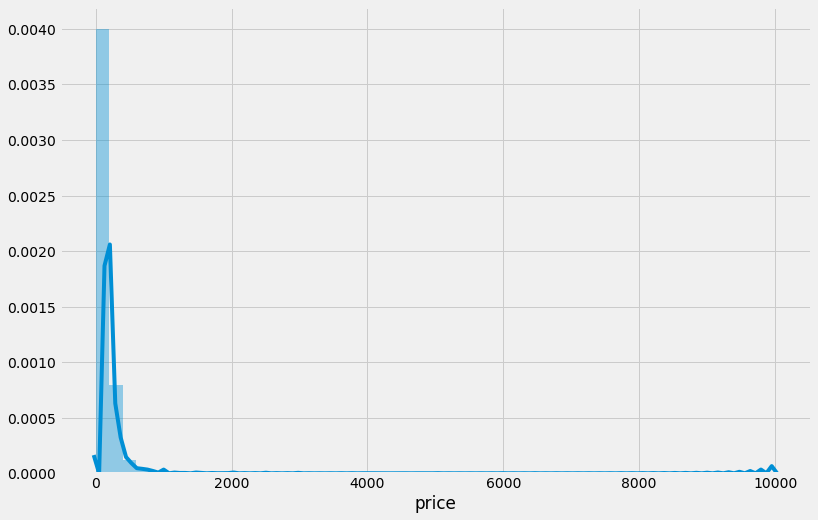

In [3]:
plt.figure(figsize=(12,8))
sns.distplot(df['price']);

## Changing into numpy.log1p and removing outlier

In [4]:
df1 = df.copy()

In [5]:
df1['price'] = np.log1p(df1['price'])

**numpy.log1p**

Return the natural logarithm of one plus the input array, element-wise.

Calculates log(1 + x).

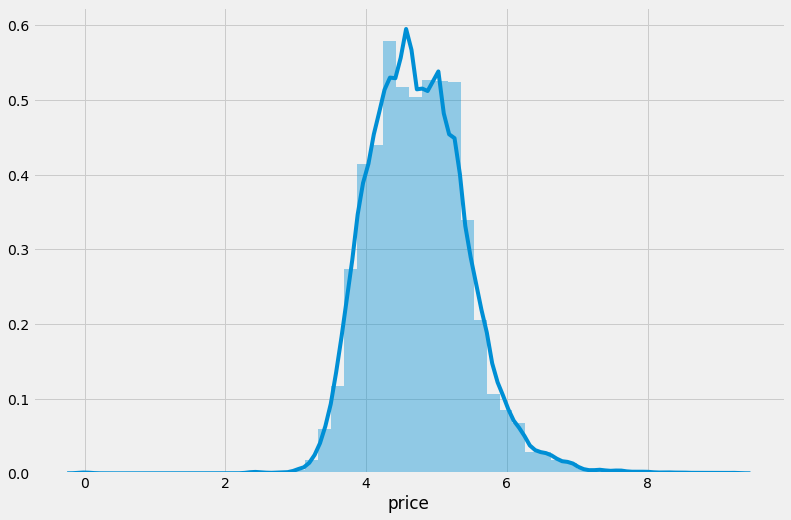

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(df1['price']);

In [7]:
# Removing Outlier with IQR
bttm_threshold, top_threshold, outlier_array = find_outlier(df1['price'])
bttm_threshold, top_threshold

(2.8655121125661713, 6.553467124521339)

In [8]:
print("Jumlah outlier =",df1[(df1['price'] < bttm_threshold) | (df1['price'] > top_threshold)].shape[0], "row")

Jumlah outlier = 637 row


In [9]:
df1 = df1[(df1['price'] >= bttm_threshold) & (df1['price'] <= top_threshold)] # 637 row deleted

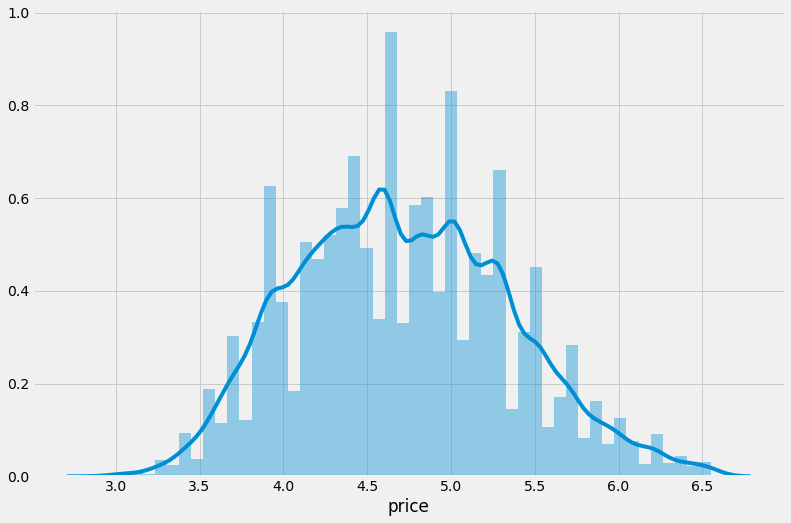

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(df1['price']);

# Determining Predictor

In [11]:
df1.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], inplace=True)
df1.fillna(0, inplace=True)
df1.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,10,9,0.10,1,0


# Encoding Categorical Feature

## With LabelEncoder()

In [12]:
df1_label_encoded = df1.copy()
df1_label_encoded['neighbourhood_group'] = LabelEncoder().fit_transform(df1_label_encoded['neighbourhood_group'])
df1_label_encoded['neighbourhood'] = LabelEncoder().fit_transform(df1_label_encoded['neighbourhood'])
df1_label_encoded['room_type'] = LabelEncoder().fit_transform(df1_label_encoded['room_type'])

In [13]:
df1_label_encoded.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,1,107,40.64749,-73.97237,1,5.010635,1,9,0.21,6,365
1,2,126,40.75362,-73.98377,0,5.420535,1,45,0.38,2,355
2,2,93,40.80902,-73.94190,1,5.017280,3,0,0.00,1,365
3,1,41,40.68514,-73.95976,0,4.499810,1,270,4.64,1,194
4,2,61,40.79851,-73.94399,0,4.394449,10,9,0.10,1,0


## With pd.get_dummies()

In [14]:
df1_label_dummies = df1.copy()
df1_label_dummies = pd.get_dummies(df1_label_dummies, prefix=['room_type'], columns=['room_type'])
df1_label_dummies = pd.get_dummies(df1_label_dummies, prefix=['neighbourhood_group'], columns=['neighbourhood_group'])
df1_label_dummies = pd.get_dummies(df1_label_dummies, prefix=['neighbourhood'], columns=['neighbourhood'])
df1_label_dummies.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,...,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside
0,40.64749,-73.97237,5.010635,1,9,0.21,6,365,0,1,...,0,0,0,0,0,0,0,0,0,0
1,40.75362,-73.98377,5.420535,1,45,0.38,2,355,1,0,...,0,0,0,0,0,0,0,0,0,0
2,40.80902,-73.94190,5.017280,3,0,0.00,1,365,0,1,...,0,0,0,0,0,0,0,0,0,0
3,40.68514,-73.95976,4.499810,1,270,4.64,1,194,1,0,...,0,0,0,0,0,0,0,0,0,0
4,40.79851,-73.94399,4.394449,10,9,0.10,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Splitting and Train Dataset

## With label_encoder

In [15]:
x = df1_label_encoded.drop(columns=['price'])
y = df1_label_encoded['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

## With label_dummies

In [16]:
x1 = df1_label_dummies.drop(columns=['price'])
y1 = df1_label_dummies['price']

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)
x1_train = RobustScaler().fit_transform(x1_train)
x1_test = RobustScaler().fit_transform(x1_test)

# Modelling ML and Evaluation

## With label_encoder

### No Polynomial

In [25]:
model = Ridge()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
print(f'Model\t = {model}')
print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
print(f'R2 Score = {round( r2_score(y_test,y_pred) * 100 , 2)}')
print('\n')

print('cross_val_score =', cross_val_score(model, x, y, scoring='r2',cv=5))

Model	 = Ridge()
RMSE	 = 0.45
MAE	 = 0.34
R2 Score = 50.35


cross_val_score = [0.43340737 0.49583727 0.4727634  0.50207163 0.53376671]


### Polynomial 2

In [29]:
model = Ridge()
poly_reg = make_pipeline(
    PF(2, include_bias=False),
    model
)

poly_reg.fit(x_train, y_train)
# predict
y_pred_poly = poly_reg.predict(x_test)
print(f'Model\t = {model}')
print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred_poly)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred_poly), 2)}')
print(f'R2 Score = {round( r2_score(y_test,y_pred_poly) * 100 , 2)}')
print('\n')
print('cross_val_score =', cross_val_score(poly_reg, x, y, scoring='r2',cv=5))

Model	 = Ridge(alpha=15)
RMSE	 = 0.41
MAE	 = 0.31
R2 Score = 58.02


cross_val_score = [0.4509039  0.53220437 0.52590007 0.56091332 0.49611262]


In [27]:
y_train_pred_poly = poly_reg.predict(x_train)

In [28]:
pd.DataFrame({'Dataset': ['label_encoder_tuned_no_poly', 'label_encoder_tuned_poly_2'], 
              'CV error': [ (cross_val_score(model, x, y, scoring='neg_root_mean_squared_error',cv=5).mean()), 
                           (cross_val_score(poly_reg, x, y, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(model, x, y, scoring='neg_root_mean_squared_error',cv=5).std()), 
                         (cross_val_score(poly_reg, x, y, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred_poly))],
              'Test Error' : [np.sqrt(mean_squared_error(y_test, y_pred)), np.sqrt(mean_squared_error(y_test, y_pred_poly))],
              'Training_R2_Score' : [r2_score(y_train,y_train_pred), r2_score(y_train,y_train_pred_poly)],
              'Test_R2_Score' : [r2_score(y_test,y_pred), r2_score(y_test,y_pred_poly)]
             }).set_index('Dataset')

,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
Dataset,,,,,,
label_encoder_tuned_no_poly,-0.453375,0.017111,0.451735,0.448881,0.500328,0.503494
label_encoder_tuned_poly_2,-0.441061,0.029397,0.414773,0.412736,0.578751,0.580235


---

## With label_dummies

In [30]:
model1 = Ridge()
model1.fit(x1_train, y1_train)
y1_pred = model1.predict(x1_test)
print(f'Model\t = {model1}')
print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y1_test, y1_pred)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y1_test,y1_pred), 2)}')
print(f'R2 Score = {round( r2_score(y1_test,y1_pred) * 100 , 2)}')
print('\n')
print('cross_val_score =', cross_val_score(model1, x1, y1, scoring='r2',cv=5))

Model	 = Ridge()
RMSE	 = 0.41
MAE	 = 0.31
R2 Score = 58.34


cross_val_score = [0.51118846 0.56015308 0.5628712  0.59227459 0.6142801 ]


In [31]:
y1_train_pred = model1.predict(x1_train)

### Tuning Model with label_dummies

In [32]:
alpha = np.linspace(3,4,10)

param = {'alpha':alpha}

model1 = Ridge()
model1_tuned = GridSearchCV(estimator=model1, param_grid=param, cv=5)

In [33]:
# Jalanin 1x aja
model1_tuned.fit(x1_train, y1_train)
print(model1_tuned.best_params_)

{'alpha': 3.0}


In [34]:
model1_tuned_GS = Ridge(alpha=3)
model1_tuned_GS.fit(x1_train, y1_train)
y1_pred_tuned = model1_tuned_GS.predict(x1_test)
print(f'Model\t = {model1_tuned_GS}')
print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y1_test, y1_pred_tuned)), 2)}')
print(f'MAE\t = {round(mean_absolute_error(y1_test,y1_pred_tuned), 2)}')
print(f'R2 Score = {round( r2_score(y1_test,y1_pred_tuned) * 100 , 2)}')
print('\n')
print('cross_val_score =', cross_val_score(model1_tuned_GS,x1, y1, scoring='r2', cv=5))

Model	 = Ridge(alpha=3)
RMSE	 = 0.41
MAE	 = 0.31
R2 Score = 58.38


cross_val_score = [0.51063895 0.55990328 0.56245943 0.59252893 0.61426339]


In [35]:
y1_train_pred_tuned = model1_tuned_GS.predict(x1_train)

In [36]:
pd.DataFrame({'Dataset': ['label_dummies', 'label_dummies_tuned'], 
              'CV error': [ (cross_val_score(model1, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean()), 
                           (cross_val_score(model1_tuned_GS,x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(model1, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std()), 
                         (cross_val_score(model1_tuned_GS,x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, y1_train_pred)), np.sqrt(mean_squared_error(y1_train, y1_train_pred_tuned))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, y1_pred)), np.sqrt(mean_squared_error(y1_test, y1_pred_tuned))],
              'Training_R2_Score' : [r2_score(y1_train,y1_train_pred), r2_score(y1_train,y1_train_pred_tuned)],
              'Test_R2_Score' : [r2_score(y1_test,y1_pred), r2_score(y1_test,y1_pred_tuned)]
             }).set_index('Dataset')

,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
Dataset,,,,,,
label_dummies,-0.415808,0.011703,0.410670,0.411157,0.587043,0.583440
label_dummies_tuned,-0.415891,0.011634,0.410927,0.410983,0.586527,0.583793


---

# Try Model using RandomForestRegressor

## With LabelEncoder

In [94]:
x = df1_label_encoded.drop(columns=['price'])
y = df1_label_encoded['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

In [95]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(x_train, y_train)
rfr_train_pred = rfr.predict(x_train)
rfr_test_pred = rfr.predict(x_test)

In [39]:
pd.DataFrame({'Dataset': ['RandomForestRegressor_labelencoder'], 
              'CV error': [ (cross_val_score(rfr, x, y, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(rfr, x, y, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y_train, rfr_train_pred))],
              'Test Error' : [np.sqrt(mean_squared_error(y_test, rfr_test_pred))],
              'Training_R2_Score' : [r2_score(y_train,rfr_train_pred)],
              'Test_R2_Score' : [r2_score(y_test,rfr_test_pred)]
             }).set_index('Dataset')

,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
Dataset,,,,,,
RandomForestRegressor_labelencoder,-0.401531,0.019577,0.14298,0.379589,0.949942,0.644951


Overfitting massively!!

In [40]:
cross_val_score(rfr, x, y, scoring='neg_root_mean_squared_error',cv=5)

array([-0.39073051, -0.38741049, -0.39606585, -0.39318071, -0.44026873])

In [49]:
cross_val_score(rfr, x, y, scoring='r2',cv=5)

array([0.54649294, 0.59875582, 0.59783266, 0.63826721, 0.60923299])

## Tuning Parameter

In [42]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop=2000,num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

In [45]:
# GridSearch 
rfr = RandomForestRegressor(random_state=42)
tuning_rfr = RandomizedSearchCV(estimator=rfr, param_distributions=param, cv=5)

In [46]:
tuning_rfr.fit(x_train, y_train)
print(tuning_rfr.best_params_)

{'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


In [47]:
rfr_tuned = RandomForestRegressor(random_state=42, n_estimators=1400, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=30, bootstrap=True)
rfr_tuned.fit(x_train, y_train)
rfr_tuned_train_pred = rfr_tuned.predict(x_train)
rfr_tuned_test_pred = rfr_tuned.predict(x_test)

In [48]:
pd.DataFrame({'Dataset': ['RandomForestRegressor_labelencoder_tuned'], 
              'CV error': [ (cross_val_score(rfr_tuned, x, y, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(rfr_tuned, x, y, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y_train, rfr_tuned_train_pred))],
              'Test Error' : [np.sqrt(mean_squared_error(y_test, rfr_tuned_test_pred))],
              'Training_R2_Score' : [r2_score(y_train,rfr_tuned_train_pred)],
              'Test_R2_Score' : [r2_score(y_test,rfr_tuned_test_pred)]
             }).set_index('Dataset')

,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
Dataset,,,,,,
RandomForestRegressor_labelencoder_tuned,-0.388706,0.011841,0.277845,0.37315,0.810973,0.656893


In [60]:
cross_val_score(rfr_tuned, x, y, scoring='neg_root_mean_squared_error',cv=5)

array([-0.38051083, -0.37840188, -0.38669051, -0.38644732, -0.41147886])

In [50]:
cross_val_score(rfr_tuned, x, y, scoring='r2',cv=5)

array([0.56990594, 0.61719945, 0.61664685, 0.65055077, 0.65866778])

---

## With label_dummies

In [52]:
x1 = df1_label_dummies.drop(columns=['price'])
y1 = df1_label_dummies['price']

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)
x1_train = RobustScaler().fit_transform(x1_train)
x1_test = RobustScaler().fit_transform(x1_test)

In [55]:
rfr2 = RandomForestRegressor(random_state=42)
rfr2.fit(x1_train, y1_train)
rfr2_train_pred = rfr2.predict(x1_train)
rfr2_test_pred = rfr2.predict(x1_test)

In [57]:
pd.DataFrame({'Dataset': ['RandomForestRegressor_labeldummies'], 
              'CV error': [ (cross_val_score(rfr2, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(rfr2, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, rfr2_train_pred))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, rfr2_test_pred))],
              'Training_R2_Score' : [r2_score(y1_train,rfr2_train_pred)],
              'Test_R2_Score' : [r2_score(y1_test,rfr2_test_pred)]
             }).set_index('Dataset')

,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
Dataset,,,,,,
RandomForestRegressor_labeldummies,-0.400783,0.017084,0.14301,0.380181,0.949921,0.643841


In [58]:
cross_val_score(rfr2, x1, y1, scoring='neg_root_mean_squared_error',cv=5)

array([-0.39185335, -0.38990514, -0.39514078, -0.39222977, -0.43478578])

In [59]:
cross_val_score(rfr2, x1, y1, scoring='r2',cv=5)

array([0.54388271, 0.59357174, 0.5997091 , 0.64001485, 0.61890533])

---

# Conclusion

In [96]:
Result = pd.concat([
    pd.DataFrame({'Dataset': ['Ridge_label_encoder_tuned_no_poly', 'Ridge_label_encoder_tuned_poly_2'], 
              'CV error': [ (cross_val_score(model, x, y, scoring='neg_root_mean_squared_error',cv=5).mean()), 
                           (cross_val_score(poly_reg, x, y, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(model, x, y, scoring='neg_root_mean_squared_error',cv=5).std()), 
                         (cross_val_score(poly_reg, x, y, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred_poly))],
              'Test Error' : [np.sqrt(mean_squared_error(y_test, y_pred)), np.sqrt(mean_squared_error(y_test, y_pred_poly))],
              'Training_R2_Score' : [r2_score(y_train,y_train_pred), r2_score(y_train,y_train_pred_poly)],
              'Test_R2_Score' : [r2_score(y_test,y_pred), r2_score(y_test,y_pred_poly)]
             }).set_index('Dataset'),
    pd.DataFrame({'Dataset': ['Ridge_label_dummies', 'Ridge_label_dummies_tuned'], 
              'CV error': [ (cross_val_score(model1, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean()), 
                           (cross_val_score(model1_tuned_GS,x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(model1, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std()), 
                         (cross_val_score(model1_tuned_GS,x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, y1_train_pred)), np.sqrt(mean_squared_error(y1_train, y1_train_pred_tuned))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, y1_pred)), np.sqrt(mean_squared_error(y1_test, y1_pred_tuned))],
              'Training_R2_Score' : [r2_score(y1_train,y1_train_pred), r2_score(y1_train,y1_train_pred_tuned)],
              'Test_R2_Score' : [r2_score(y1_test,y1_pred), r2_score(y1_test,y1_pred_tuned)]
             }).set_index('Dataset'),
    pd.DataFrame({'Dataset': ['RandomForestRegressor_labelencoder'], 
              'CV error': [ (cross_val_score(rfr, x, y, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(rfr, x, y, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y_train, rfr_train_pred))],
              'Test Error' : [np.sqrt(mean_squared_error(y_test, rfr_test_pred))],
              'Training_R2_Score' : [r2_score(y_train,rfr_train_pred)],
              'Test_R2_Score' : [r2_score(y_test,rfr_test_pred)]
             }).set_index('Dataset'),
    pd.DataFrame({'Dataset': ['RandomForestRegressor_labelencoder_tuned'], 
              'CV error': [ (cross_val_score(rfr_tuned, x, y, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(rfr_tuned, x, y, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y_train, rfr_tuned_train_pred))],
              'Test Error' : [np.sqrt(mean_squared_error(y_test, rfr_tuned_test_pred))],
              'Training_R2_Score' : [r2_score(y_train,rfr_tuned_train_pred)],
              'Test_R2_Score' : [r2_score(y_test,rfr_tuned_test_pred)]
             }).set_index('Dataset'),
    pd.DataFrame({'Dataset': ['RandomForestRegressor_labeldummies'], 
              'CV error': [ (cross_val_score(rfr2, x1, y1, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(rfr2, x1, y1, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y1_train, rfr2_train_pred))],
              'Test Error' : [np.sqrt(mean_squared_error(y1_test, rfr2_test_pred))],
              'Training_R2_Score' : [r2_score(y1_train,rfr2_train_pred)],
              'Test_R2_Score' : [r2_score(y1_test,rfr2_test_pred)]
             }).set_index('Dataset')
      
], axis=0, ignore_index=False)
Result

,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
Dataset,,,,,,
Ridge_label_encoder_tuned_no_poly,-0.454098,0.017323,0.451735,0.448881,0.500328,0.503494
Ridge_label_encoder_tuned_poly_2,-0.442283,0.029276,0.414773,0.412745,0.578751,0.580215
Ridge_label_dummies,-0.415808,0.011703,0.410670,0.411157,0.587043,0.583440
Ridge_label_dummies_tuned,-0.415891,0.011634,0.410927,0.410983,0.586527,0.583793
RandomForestRegressor_labelencoder,-0.401531,0.019577,0.142980,0.379589,0.949942,0.644951
RandomForestRegressor_labelencoder_tuned,-0.388706,0.011841,0.277845,0.373150,0.810973,0.656893
RandomForestRegressor_labeldummies,-0.400783,0.017084,0.143010,0.380181,0.949921,0.643841


---

# Actual Vs Predicted for Ridge Model

Here we are using **Ridge_label_dummies_tuned**

In [75]:
ridge_error_airbnb = pd.DataFrame({'Actual Price' : np.expm1(np.array(y1_test).flatten()),
                                  'Predicted Price' : np.expm1(np.array(y1_pred_tuned).flatten())}).head(50)
ridge_error_airbnb.head()

,Actual Price,Predicted Price
0,90.0,104.908103
1,45.0,43.736263
2,250.0,209.302330
3,50.0,60.818289
4,275.0,174.801857


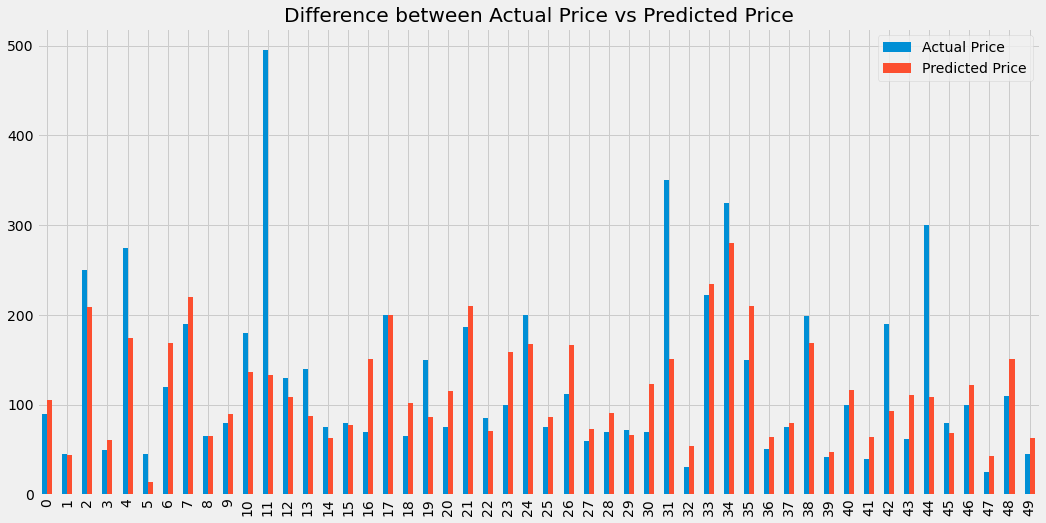

In [76]:
ridge_error_airbnb.plot(kind='bar', figsize=(16, 8))
plt.title('Difference between Actual Price vs Predicted Price')
plt.show()

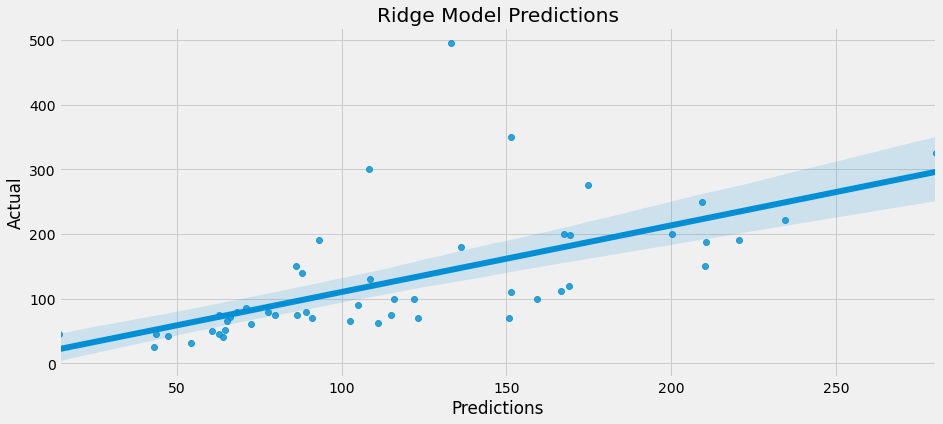

In [81]:
plt.figure(figsize=(14,6))
sns.regplot('Predicted Price','Actual Price', data=ridge_error_airbnb)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Ridge Model Predictions")
plt.grid(True)
plt.show()

---

# Actual Vs Predicted for RandomForest Model

Here we are using **RandomForestRegressor_labelencoder_tuned**

In [85]:
rf_error_airbnb = pd.DataFrame({'Actual Price' : np.expm1(np.array(y_test).flatten()),
                                  'Predicted Price' : np.expm1(np.array(rfr_tuned_test_pred).flatten())}).head(50)
rf_error_airbnb.head()

,Actual Price,Predicted Price
0,90.0,86.947438
1,45.0,51.513842
2,250.0,213.102838
3,50.0,69.463738
4,275.0,175.004602


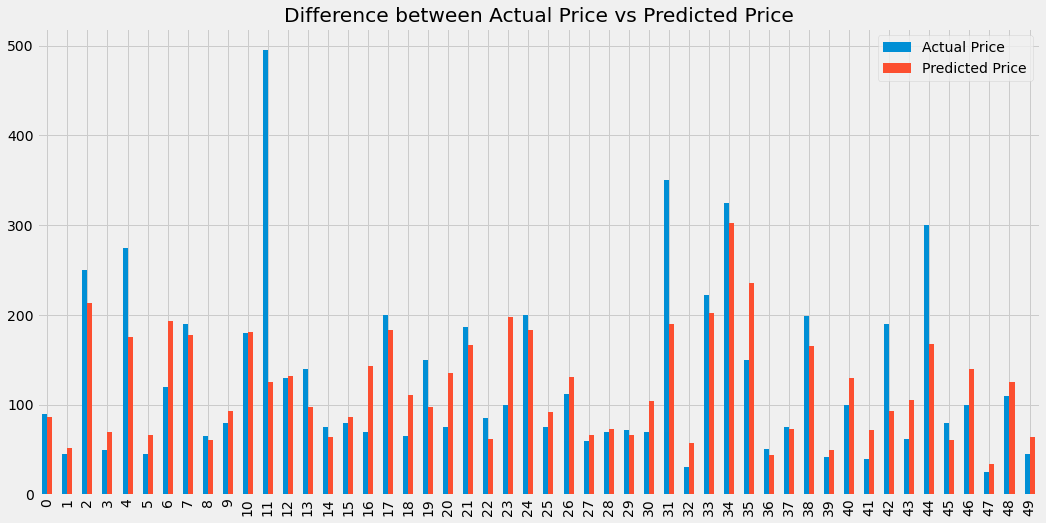

In [83]:
rf_error_airbnb.plot(kind='bar', figsize=(16, 8))
plt.title('Difference between Actual Price vs Predicted Price')
plt.show()

---

# Cobain tanpa robustscaler

In [89]:
x = df1_label_encoded.drop(columns=['price'])
y = df1_label_encoded['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [90]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(x_train, y_train)
rfr_train_pred = rfr.predict(x_train)
rfr_test_pred = rfr.predict(x_test)

In [91]:
pd.DataFrame({'Dataset': ['RandomForestRegressor_labelencoder'], 
              'CV error': [ (cross_val_score(rfr, x, y, scoring='neg_root_mean_squared_error',cv=5).mean())],
              'CV std': [ (cross_val_score(rfr, x, y, scoring='neg_root_mean_squared_error',cv=5).std())],
              'Training Error' : [np.sqrt(mean_squared_error(y_train, rfr_train_pred))],
              'Test Error' : [np.sqrt(mean_squared_error(y_test, rfr_test_pred))],
              'Training_R2_Score' : [r2_score(y_train,rfr_train_pred)],
              'Test_R2_Score' : [r2_score(y_test,rfr_test_pred)]
             }).set_index('Dataset')

,CV error,CV std,Training Error,Test Error,Training_R2_Score,Test_R2_Score
Dataset,,,,,,
RandomForestRegressor_labelencoder,-0.401531,0.019577,0.142978,0.375053,0.949944,0.653385
